# Tools for Analyzing Time Series of Satellite Imagery (TATSSI)

In [1]:
%autosave 0
# Import TATSSI libraries
from helpers import utils
from TATSSI.notebooks.helpers.qa_analytics import Analytics
from TATSSI.notebooks.helpers.time_series_interpolation import TimeSeriesInterpolation

Autosave disabled


## QA analytics

In the TATSSI Downloaders demonstrator we downloaded some MODIS data, the [MOD13A2.006](https://lpdaac.usgs.gov/products/mod13a2v006/) product for 2017. This product contains several layers including the EVI and NDVI, at 1km every 16 days, as well as associated Quality Assessment flags.

Then, we created a time series for this dataset. Now we need to perfrom a systematic analysis of the per-pixel QA flags that will allow to keep only the best data for scientific purposes or to reach a compromise between the amount of data we can keep and the amount of data needed to characterise the land surface (or ocean surface).

1. For the specific QA layer we need to select the QA flags for the data we want to keep. If you **select** a QA flag means that the data will be kept for further analysis.

2. Once the QA flags selection is done, the data will be masked and per-pixel two products will be produced:
  - The percentage of data available for further processing and
  - The maxium gap-length in the time series
  
3. Based on those variables, it is possible to select/unselect different QA flags and recompute the data availibility percentage and the max gap-lenght.

In [2]:
# Set data directory
source_dir = '../../data/MOD13A2.006/'
# Set product, it must match product name in TATSSI catalogue
product, version = 'MOD13A2', '006'
# Year to analyse
#year = 2013
start, end = '2016-10-01', '2019-03-31'

We have to create a TATSSI QA analytics object to perform a systematic analysis of the different QA layers and associated flags:

In [3]:
# Create the QA analytics object
qa_analytics = Analytics(source_dir=source_dir, product=product,chunked=True,
                         version=version, start=start, end=end) #, year=year)

Every product might have one or more QA layers. Hence we need to select the QA layer to analyse. In order to get the number of QA layers we can get the length of the ```qa_analytics.qa_defs``` list with ```len(qa_analytics.qa_defs)```:

In [4]:
print(len(qa_analytics.qa_defs))

2


## Selecting the QA layer to analyse
We have to layers, if you (still) remember from the QA analysis session, the MOD13A2 has indeed 2 QA layers, let's have a quick look to remind the content of every layer. In Python all arrays, lists, etc. are 0-based index, therefore if we want to access the first element, it'll be index 0, second element, it'll be index 1, etc.

In [5]:
qa_analytics.qa_defs[0]

,ProductAndVersion,QualityLayer,Name,Value,Description,Acceptable,Length
0,MOD13A2.006,_1_km_16_days_pixel_reliability,MODLAND,0,"Good data, use with confidence",True,2
1,MOD13A2.006,_1_km_16_days_pixel_reliability,MODLAND,1,"Marginal data, Useful, but look at other QA in...",False,2
2,MOD13A2.006,_1_km_16_days_pixel_reliability,MODLAND,10,Snow/Ice Target covered with snow/ice,False,2
3,MOD13A2.006,_1_km_16_days_pixel_reliability,MODLAND,11,"Cloudy data, Target not visible, covered with ...",False,2


The ```_1_km_16_days_pixel_reliability``` QA layer has only one QA flag, ```MODLAND``` with four values to analyse, it seems to be fairly basic (and boring), let's have a look to the other layer.

In [6]:
qa_analytics.qa_defs[1]

,ProductAndVersion,QualityLayer,Name,Value,Description,Acceptable,Length
0,MOD13A2.006,_1_km_16_days_VI_Quality,MODLAND,0,"VI produced, good quality",True,2
1,MOD13A2.006,_1_km_16_days_VI_Quality,MODLAND,1,"VI produced, but check other QA",False,2
2,MOD13A2.006,_1_km_16_days_VI_Quality,MODLAND,10,"Pixel produced, but most probably cloudy",False,2
3,MOD13A2.006,_1_km_16_days_VI_Quality,MODLAND,11,Pixel not produced due to other reasons than c...,False,2
4,MOD13A2.006,_1_km_16_days_VI_Quality,VI Usefulness,0,Highest quality,None,4
5,MOD13A2.006,_1_km_16_days_VI_Quality,VI Usefulness,1,Lower quality,None,4
6,MOD13A2.006,_1_km_16_days_VI_Quality,VI Usefulness,10,Decreasing quality (0010),None,4
7,MOD13A2.006,_1_km_16_days_VI_Quality,VI Usefulness,11,Decreasing quality (0011),None,4
8,MOD13A2.006,_1_km_16_days_VI_Quality,VI Usefulness,100,Decreasing quality (0100),None,4
9,MOD13A2.006,_1_km_16_days_VI_Quality,VI Usefulness,101,Decreasing quality (0101),None,4


This definitely is more useful, we'll use the ```_1_km_16_days_VI_Quality``` QA layer to perform the analysis. But as a starting point, let's select the ```_1_km_16_days_pixel_reliability``` layer.

It is neccesary now to set the QA definition into the ```qa_analytics``` object:

In [7]:
# Set the _1_km_16_days_VI_Quality (index 0) definition to be the one to perform the analysis
# later on we can just change the 0 for 1 to use the _1_km_16_days_VI_Quality layer

qa_analytics.qa_def = qa_analytics.qa_defs[0]

## Performing the QA analytics
Now we can luanch the TATSSI QA analytics User Interface to select the QA flags that we consider adequate for out purposes.
1. Click on one the ```QA Parameter name``` list that contains all the QA parameters for the selected product
2. Then click on one or more of the ```Description``` list that contains the QA flag description. To select multiple descriptions you can click-and-drag or keep pressing the ```CTRL``` key and click on the description to select.
3. To perform the QA analytics click on the ```QA analytics``` button. This will generate the following layers:
 * A boolean ```mask``` object where ```True``` indicates that the pixel will be kept for further processing.
 * The percentage of data avilable after masking in the ```pct_data_available``` object
 * The maximum gap length in the time series in the ```max_gap_length``` object.
 
Clicking on the ```Select ALL``` button will select **all** QA flags, this will be equivalent to have **all** the data without any masking.
The ```Default selection``` button selects the first QA flag from each QA parameter.

The ```Save QA analytics``` save the current QA parameters selection into a JSON file with the name of the current QA layer, the ```Load QA analytics``` button loads the selection if the file already exists.

In [8]:
# Launch the TATSSI QA analytics User Interface
qa_analytics.ui()

HTML(value='<b>_1_km_16_days_pixel_reliability</b>', description='QA layer:')

IntProgress(value=0, layout=Layout(width='50%'), max=1, style=ProgressStyle(description_width='initial'))

IntProgress(value=0, description='Computing max gap length...', layout=Layout(width='50%'), max=10, style=Prog…

We can examine now the user QA selection, it is stored in the ```qa_analytics.user_qa_selection``` dictionary:

In [9]:
qa_analytics.user_qa_selection

OrderedDict([('MODLAND', ('Good data, use with confidence',))])

Now we can visualise the percentage of data available and the max gap-lenght computed using the user QA settings. In case you want to plot the data using a diferent colorbar, pass the ```cbar``` argument to the ```plot_analytics``` method. Have a look to the different [colobars](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) available.

<IPython.core.display.Javascript object>


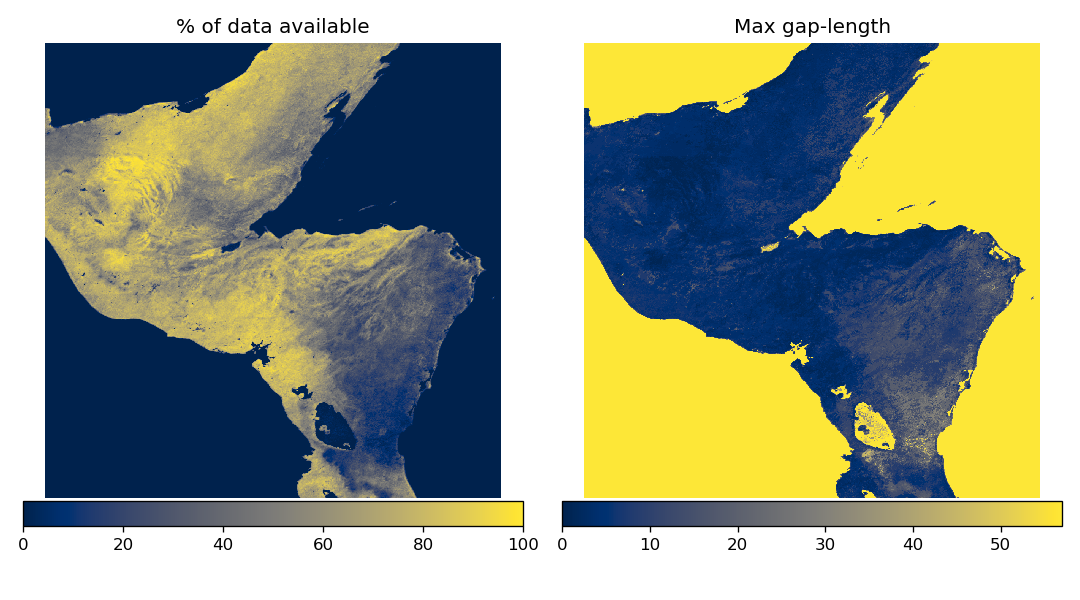

In [10]:
# QA analytics layers
cmap='cividis'
qa_analytics.plot_analytics(cmap=cmap, dpi=120)

## Time series interpolation
Once the masking of pixels according to the QA selection has been performed, TATSSI allows to:
* Fill the gaps in the time series using different interpolation techniques

<IPython.core.display.Javascript object>


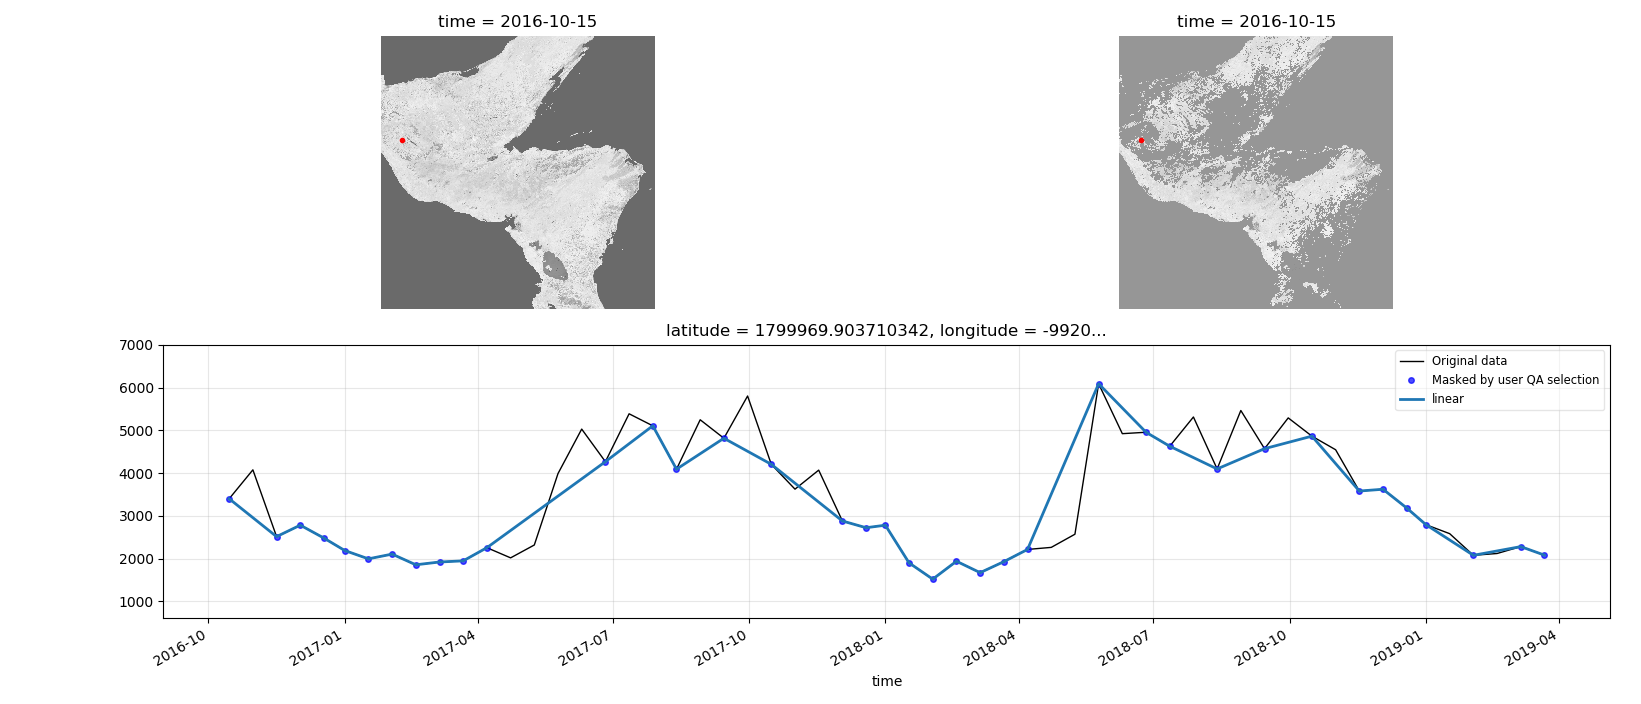

In [11]:
# Time series interpolation
tsi = TimeSeriesInterpolation(qa_analytics)

Once you selected the interpolation method or methods to apply to the dataset, we can perform the interpolation by using the ```interpolate``` method from the Time Series Analysis object:

In [13]:
# Apply the interpolation, grab a coffee or a mezcal it might take a few minutes...
# Particulary if smoothing consider a small tile, e.g. 50
#tsa.interpolate(tile_size=20)
%time tsi.interpolate(n_workers=3, threads_per_worker=1, memory_limit='4GB')

IntProgress(value=0, layout=Layout(width='75%'), max=1, style=ProgressStyle(description_width='initial'))

/python/anaconda3/lib/python3.7/site-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


CPU times: user 8.86 s, sys: 1.04 s, total: 9.9 s
Wall time: 44.3 s


In [14]:
# Explore the interpolated file
!gdalinfo ../../data/MOD13A2.006/1_km_16_days_EVI/interpolated/*.tif

Driver: GTiff/GeoTIFF
Files: ../../data/MOD13A2.006/1_km_16_days_EVI/interpolated/MOD13A2.006._1_km_16_days_EVI.linear.tif
Size is 1200, 1200
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["unnamed ellipse",
        DATUM["unknown",
            SPHEROID["unnamed",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (-10007554.676999999210238,2223901.039332999847829)
Pixel Size = (926.625433055840631,-926.625433054990026)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (-10007554.677, 2223901.039) ( 95d46'33.60"W, 20d 0' 0.00"N)
Lower Left  (-10007554.677, 1111950.520) ( 91d23'18.22"W, 10d 0' 0.00"N)
Upper Right (-8895604.157, 2223901.039) ( 85d 8' 3.20"W, 20d 0' 0

## EX5 - Find the best QA settings and interpolation method to capture the vegetation seasonality around "La Angostura"

* Hint - Change the QA settings, click on some pixels aroung "La Angostura"